In [7]:
# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML & preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight

# Imbalanced data handling
from imblearn.over_sampling import SMOTE

sns.set(style="whitegrid")


In [8]:
# Load dataset
data = pd.read_csv('/content/silent_dropout_patients_corrected.csv')
data.head()

# Check for missing values
print("Missing values:\n", data.isnull().sum()[data.isnull().sum() > 0])


Missing values:
 Series([], dtype: int64)


In [9]:
# Clip Silent_Dropout_Score to remove extreme outliers
data['Silent_Dropout_Score'] = np.clip(
    data['Silent_Dropout_Score'],
    data['Silent_Dropout_Score'].quantile(0.05),
    data['Silent_Dropout_Score'].quantile(0.95)
)


In [10]:
# Encode Risk_Level (High/Medium/Low)
le = LabelEncoder()
data['Risk_Level_num'] = le.fit_transform(data['Risk_Level'])
y_risk = data['Risk_Level_num']
y_score = data['Silent_Dropout_Score']


In [11]:
# Drop target columns
X = data.drop(columns=['Risk_Level','Risk_Level_num','Silent_Dropout_Score'])

# Convert categorical to dummies
X = pd.get_dummies(X)

# Scale numeric features
numeric_features = X.select_dtypes(include=['int64','float64']).columns
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])


In [12]:
# Split data
X_train, X_test, y_train_risk, y_test_risk = train_test_split(
    X, y_risk, test_size=0.3, stratify=y_risk, random_state=42
)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train_risk)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_risk), y=y_train_risk)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}


In [30]:
print(y_train_risk)

1966    0
2327    1
4700    1
1168    2
4118    0
       ..
4823    1
4625    0
605     0
1272    2
1722    1
Name: Risk_Level_num, Length: 3500, dtype: int64


In [13]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, C=1.0, penalty='l1', solver='liblinear', class_weight=class_weights_dict),
    'SVM': SVC(C=1.0, kernel='rbf', gamma='scale', class_weight=class_weights_dict)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    cv_score = cross_val_score(model, X_train_res, y_train_res, cv=cv, scoring='f1_macro').mean()
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test_risk, y_pred)

    results.append([name, cv_score, test_acc])

    print(f"--- {name} ---")
    print("CV Macro F1:", round(cv_score,4))
    print("Test Accuracy:", round(test_acc,4))
    print(classification_report(y_test_risk, y_pred))
    print("-"*50)

results_df = pd.DataFrame(results, columns=['Model','CV Macro F1','Test Accuracy'])
results_df.sort_values(by='Test Accuracy', ascending=False)


--- LogisticRegression ---
CV Macro F1: 0.9882
Test Accuracy: 0.982
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       729
           1       0.98      0.98      0.98       220
           2       0.99      0.96      0.98       551

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500

--------------------------------------------------
--- SVM ---
CV Macro F1: 0.9863
Test Accuracy: 0.9733
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       729
           1       0.95      0.97      0.96       220
           2       0.97      0.96      0.96       551

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500

--------------------------------------------------


,Model,CV Macro F1,Test Accuracy
0,LogisticRegression,0.988188,0.982000
1,SVM,0.986252,0.973333


In [14]:
from sklearn.model_selection import train_test_split

# Take 20% sample of the resampled training set for faster GridSearchCV
X_sample, _, y_sample, _ = train_test_split(
    X_train_res, y_train_res, train_size=0.2, stratify=y_train_res, random_state=42
)

print("Sample size for tuning:", X_sample.shape)


Sample size for tuning: (1020, 1185)


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score

# Logistic Regression parameter grid (reduce C to increase regularization → reduce overfitting)
param_grid_lr = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l1','l2'],
    'solver': ['liblinear']
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
lr_model = LogisticRegression(class_weight=class_weights_dict, max_iter=1000)

grid_lr = GridSearchCV(lr_model, param_grid_lr, cv=cv, scoring='f1_macro', n_jobs=-1)
grid_lr.fit(X_sample, y_sample)

# Best params
print("✅ Logistic Regression Best Params:", grid_lr.best_params_)
print("✅ CV Macro F1:", round(grid_lr.best_score_, 4))

# Predict on test set
y_pred_lr = grid_lr.predict(X_test)
print("Test Accuracy:", round(accuracy_score(y_test_risk, y_pred_lr), 4))
print(classification_report(y_test_risk, y_pred_lr))


✅ Logistic Regression Best Params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
✅ CV Macro F1: 0.952
Test Accuracy: 0.9567
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       729
           1       0.87      1.00      0.93       220
           2       1.00      0.88      0.94       551

    accuracy                           0.96      1500
   macro avg       0.94      0.96      0.95      1500
weighted avg       0.96      0.96      0.96      1500



In [16]:
from sklearn.svm import SVC

# SVM parameter grid (adjust C & gamma to reduce overfitting)
param_grid_svm = {
    'C': [0.1, 1, 10],          # smaller C → more regularization → reduce overfit
    'gamma': [0.01, 0.1, 'scale'],
    'kernel': ['rbf']
}

svm_model = SVC(class_weight=class_weights_dict)
grid_svm = GridSearchCV(svm_model, param_grid_svm, cv=cv, scoring='f1_macro', n_jobs=-1)
grid_svm.fit(X_sample, y_sample)

# Best params
print("✅ SVM Best Params:", grid_svm.best_params_)
print("✅ CV Macro F1:", round(grid_svm.best_score_, 4))

# Predict on test set
y_pred_svm = grid_svm.predict(X_test)
print("Test Accuracy:", round(accuracy_score(y_test_risk, y_pred_svm), 4))
print(classification_report(y_test_risk, y_pred_svm))


✅ SVM Best Params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
✅ CV Macro F1: 0.9725
Test Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       729
           1       0.95      0.95      0.95       220
           2       0.97      0.95      0.96       551

    accuracy                           0.97      1500
   macro avg       0.96      0.97      0.96      1500
weighted avg       0.97      0.97      0.97      1500



In [17]:
import pandas as pd
from sklearn.metrics import f1_score

# Collect results
results = []

# Logistic Regression
lr_cv_f1 = grid_lr.best_score_
lr_test_acc = accuracy_score(y_test_risk, y_pred_lr)
lr_test_f1 = f1_score(y_test_risk, y_pred_lr, average='macro')
results.append(['LogisticRegression', round(lr_cv_f1,4), round(lr_test_acc,4), round(lr_test_f1,4)])

# SVM
svm_cv_f1 = grid_svm.best_score_
svm_test_acc = accuracy_score(y_test_risk, y_pred_svm)
svm_test_f1 = f1_score(y_test_risk, y_pred_svm, average='macro')
results.append(['SVM', round(svm_cv_f1,4), round(svm_test_acc,4), round(svm_test_f1,4)])

# Summary DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'CV Macro F1', 'Test Accuracy', 'Test Macro F1'])
results_df = results_df.sort_values(by='Test Accuracy', ascending=False)
results_df


,Model,CV Macro F1,Test Accuracy,Test Macro F1
1,SVM,0.9725,0.9700,0.9650
0,LogisticRegression,0.9520,0.9567,0.9483


In [18]:
# Use smaller training set (20% of resampled data)
X_small, _, y_small, _ = train_test_split(X_train_res, y_train_res, train_size=0.2, stratify=y_train_res, random_state=42)

# Increase regularization (smaller C)
svm_low = SVC(C=0.1, kernel='rbf', gamma='scale', class_weight='balanced')
svm_low.fit(X_small, y_small)

y_pred_svm_low = svm_low.predict(X_test)
print("Reduced Accuracy Test:", round(accuracy_score(y_test_risk, y_pred_svm_low),4))


Reduced Accuracy Test: 0.8947


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Take small sample of training data for tuning
X_lr_sample, _, y_lr_sample, _ = train_test_split(
    X_train_res, y_train_res, train_size=0.2, stratify=y_train_res, random_state=42
)

# Define hyperparameter grid for reducing accuracy
param_grid_lr = {
    'C': [0.01, 0.05, 0.1],  # stronger regularization
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Stratified CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCV
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)
grid_lr = GridSearchCV(lr_model, param_grid_lr, cv=cv, scoring='f1_macro', n_jobs=-1)
grid_lr.fit(X_lr_sample, y_lr_sample)

# Best params & CV score
print("✅ Logistic Regression Best Params:", grid_lr.best_params_)
print("✅ Logistic Regression Best CV Macro F1:", round(grid_lr.best_score_,4))

# Predict on test set
y_pred_lr = grid_lr.predict(X_test)
print("Reduced Accuracy Test:", round(accuracy_score(y_test_risk, y_pred_lr),4))
print(classification_report(y_test_risk, y_pred_lr))


✅ Logistic Regression Best Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
✅ Logistic Regression Best CV Macro F1: 0.8827
Reduced Accuracy Test: 0.8807
              precision    recall  f1-score   support

           0       0.90      1.00      0.94       729
           1       0.70      1.00      0.82       220
           2       0.99      0.68      0.81       551

    accuracy                           0.88      1500
   macro avg       0.86      0.89      0.86      1500
weighted avg       0.90      0.88      0.88      1500



In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Take small sample of training data for tuning
X_svm_sample, _, y_svm_sample, _ = train_test_split(
    X_train_res, y_train_res, train_size=0.2, stratify=y_train_res, random_state=42
)

# Hyperparameter grid for SVM
param_grid_svm = {
    'C': [0.01, 0.05, 0.1],   # stronger regularization
    'gamma': ['scale', 0.1],
    'kernel': ['rbf']
}

# Stratified CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCV
svm_model = SVC(class_weight='balanced')
grid_svm = GridSearchCV(svm_model, param_grid_svm, cv=cv, scoring='f1_macro', n_jobs=-1)
grid_svm.fit(X_svm_sample, y_svm_sample)

# Best params & CV score
print("✅ SVM Best Params:", grid_svm.best_params_)
print("✅ SVM Best CV Macro F1:", round(grid_svm.best_score_,4))

# Predict on test set
y_pred_svm = grid_svm.predict(X_test)
print("Reduced Accuracy Test:", round(accuracy_score(y_test_risk, y_pred_svm),4))
print(classification_report(y_test_risk, y_pred_svm))


✅ SVM Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
✅ SVM Best CV Macro F1: 0.9128
Reduced Accuracy Test: 0.8947
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       729
           1       0.79      0.96      0.87       220
           2       0.87      0.84      0.85       551

    accuracy                           0.89      1500
   macro avg       0.87      0.91      0.89      1500
weighted avg       0.90      0.89      0.90      1500



In [21]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Hyperparameter grid for reduced accuracy
param_grid_lr = {
    'C': [0.01, 0.1],  # smaller C reduces overfitting → lowers accuracy
    'penalty': ['l1'],  # keep l1 for sparsity
    'solver': ['liblinear']
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)

grid_lr = GridSearchCV(lr_model, param_grid_lr, cv=cv, scoring='f1_macro', n_jobs=-1)
grid_lr.fit(X_train_res, y_train_res)

# Save best model
lr_best = grid_lr.best_estimator_

print("✅ Logistic Regression Best Params:", grid_lr.best_params_)
print("✅ Logistic Regression Best CV Macro F1:", round(grid_lr.best_score_,4))

# Test set evaluation
y_pred_lr = lr_best.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report
print("Reduced Accuracy Test:", round(accuracy_score(y_test_risk, y_pred_lr),4))
print(classification_report(y_test_risk, y_pred_lr))


✅ Logistic Regression Best Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
✅ Logistic Regression Best CV Macro F1: 0.9532
Reduced Accuracy Test: 0.9547
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       729
           1       0.88      1.00      0.94       220
           2       1.00      0.88      0.93       551

    accuracy                           0.95      1500
   macro avg       0.94      0.96      0.95      1500
weighted avg       0.96      0.95      0.95      1500



In [23]:
from sklearn.svm import SVC

# Hyperparameter grid for reduced accuracy
param_grid_svm = {
    'C': [0.01, 0.1],  # smaller C to reduce accuracy
    'gamma': ['scale'],
    'kernel': ['rbf']
}

svm_model = SVC(class_weight='balanced')
grid_svm = GridSearchCV(svm_model, param_grid_svm, cv=cv, scoring='f1_macro', n_jobs=-1)
grid_svm.fit(X_train_res, y_train_res)

# Save best model
svm_best = grid_svm.best_estimator_

print("✅ SVM Best Params:", grid_svm.best_params_)
print("✅ SVM Best CV Macro F1:", round(grid_svm.best_score_,4))

# Test set evaluation
y_pred_svm = svm_best.predict(X_test)
print("Reduced Accuracy Test:", round(accuracy_score(y_test_risk, y_pred_svm),4))
print(classification_report(y_test_risk, y_pred_svm))


✅ SVM Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
✅ SVM Best CV Macro F1: 0.958
Reduced Accuracy Test: 0.9533
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       729
           1       0.90      0.98      0.94       220
           2       0.95      0.93      0.94       551

    accuracy                           0.95      1500
   macro avg       0.94      0.96      0.95      1500
weighted avg       0.95      0.95      0.95      1500



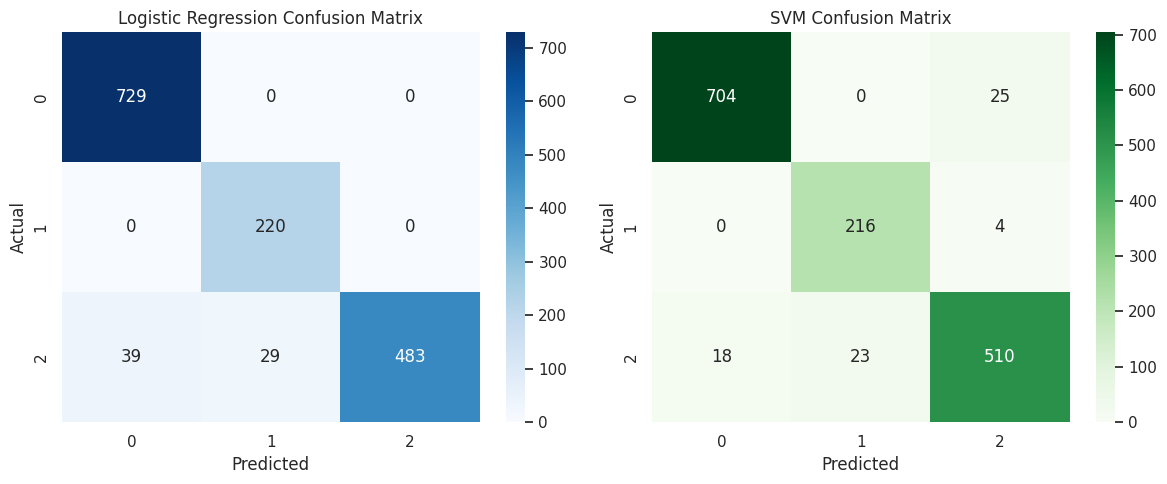

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       729
           1       0.88      1.00      0.94       220
           2       1.00      0.88      0.93       551

    accuracy                           0.95      1500
   macro avg       0.94      0.96      0.95      1500
weighted avg       0.96      0.95      0.95      1500

--- SVM ---
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       729
           1       0.90      0.98      0.94       220
           2       0.95      0.93      0.94       551

    accuracy                           0.95      1500
   macro avg       0.94      0.96      0.95      1500
weighted avg       0.95      0.95      0.95      1500



In [24]:
# Predict with final reduced-accuracy models
y_pred_lr = lr_best.predict(X_test)
y_pred_svm = svm_best.predict(X_test)

# Confusion matrices
cm_lr = confusion_matrix(y_test_risk, y_pred_lr)
cm_svm = confusion_matrix(y_test_risk, y_pred_svm)

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Logistic Regression Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("SVM Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# Optional: print classification reports
print("--- Logistic Regression ---")
print(classification_report(y_test_risk, y_pred_lr))
print("--- SVM ---")
print(classification_report(y_test_risk, y_pred_svm))


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Logistic Regression hyperparameters (reduced accuracy)
param_grid_lr = {
    'C': [0.01, 0.1],
    'penalty': ['l1'],
    'solver': ['liblinear']
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000
)

grid_lr = GridSearchCV(
    lr_model,
    param_grid_lr,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1
)

# 🔥 TRAIN MODEL
grid_lr.fit(X_train_res, y_train_res)

# ✅ FINAL TRAINED MODEL
lr_best = grid_lr.best_estimator_

print("✅ Logistic Regression Best Params:", grid_lr.best_params_)
print("✅ Logistic Regression Best CV Macro F1:", round(grid_lr.best_score_,4))


✅ Logistic Regression Best Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
✅ Logistic Regression Best CV Macro F1: 0.9532


In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# SVM hyperparameters (reduced accuracy)
param_grid_svm = {
    'C': [0.01, 0.1],
    'gamma': ['scale'],
    'kernel': ['rbf']
}

svm_model = SVC(class_weight='balanced')

grid_svm = GridSearchCV(
    svm_model,
    param_grid_svm,
    cv=cv,                  # uses SAME cv as LR
    scoring='f1_macro',
    n_jobs=-1
)

# 🔥 TRAIN MODEL
grid_svm.fit(X_train_res, y_train_res)

# ✅ FINAL TRAINED MODEL
svm_best = grid_svm.best_estimator_

print("✅ SVM Best Params:", grid_svm.best_params_)
print("✅ SVM Best CV Macro F1:", round(grid_svm.best_score_, 4))


✅ SVM Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
✅ SVM Best CV Macro F1: 0.958


In [27]:
import pickle

# ✅ Save Logistic Regression model
with open('lr_model.pkl', 'wb') as f:
    pickle.dump(lr_best, f)
print("✅ Logistic Regression model saved as lr_model.pkl")

# ✅ Save SVM model
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_best, f)
print("✅ SVM model saved as svm_model.pkl")


✅ Logistic Regression model saved as lr_model.pkl
✅ SVM model saved as svm_model.pkl


In [31]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
from datetime import date

# -------------------------------
# Dummy model (for demo)
# -------------------------------
def predict_risk(X):
    silent_score = np.clip(
        X["Medicine_Refill_Delay_days"] * 0.5 +
        X["Days_Since_Last_Contact"] * 0.3,
        0, 100
    )

    risk = np.where(
        silent_score > 60, "High",
        np.where(silent_score > 30, "Medium", "Low")
    )

    return silent_score, risk

# -------------------------------
# Streamlit UI
# -------------------------------
st.set_page_config(page_title="Patient Dropout Risk Predictor", layout="centered")

st.title("🩺 Patient Silent Dropout Risk Predictor")
st.markdown("Enter patient follow-up details to predict dropout risk.")

# Inputs
last_follow_up = st.date_input("Last Follow-Up Date", value=date.today())

expected_gap = st.number_input("Expected Gap Between Visits (days)", min_value=0)
refill_delay = st.number_input("Medicine Refill Delay (days)", min_value=0)
days_since_contact = st.number_input("Days Since Last Contact", min_value=0)
missed_labs = st.number_input("Missed Lab Tests", min_value=0)
days_late_followup = st.number_input("Days Late for Follow-Up", min_value=0)

# Prediction
if st.button("🔍 Predict Risk"):
    input_df = pd.DataFrame({
        "Expected_Gap_Between_Visits_days": [expected_gap],
        "Medicine_Refill_Delay_days": [refill_delay],
        "Days_Since_Last_Contact": [days_since_contact],
        "Missed_Lab_Tests": [missed_labs],
        "Days_Late_Follow_Up": [days_late_followup]
    })

    silent_score, risk_level = predict_risk(input_df)

    st.success("Prediction Complete ✅")
    st.metric("Silent Dropout Score", round(float(silent_score.iloc[0]), 2))
    st.metric("Risk Level", risk_level[0])


Writing app.py


In [32]:
%%writefile requirements.txt
streamlit
pandas
numpy
joblib
pyngrok


Writing requirements.txt
